## Дерево решений

In [1]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

import sklearn

from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

### Загрузим уже знакомый датасет

In [10]:
data = load_boston()
x = data['data']
y = data['target']
x = pd.DataFrame(x, columns=data['feature_names'])

y_logits = (y > np.median(y)).astype('int')

### Классификация

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y_logits, test_size=0.4, random_state=42)

In [192]:
model = LogisticRegression(max_iter=10000)
model.fit(x_train, y_train)
print('\t\t\tЛогистическая регрессия:\n', classification_report(y_test, model.predict(x_test) > 0.5), '\n')

model = DecisionTreeClassifier()
model.fit(x_train, y_train)
print('\t\t\tДерево решений:\n', classification_report(y_test, model.predict(x_test) > 0.5))

			Логистическая регрессия:
               precision    recall  f1-score   support

           0       0.92      0.83      0.87       119
           1       0.79      0.89      0.84        84

    accuracy                           0.86       203
   macro avg       0.85      0.86      0.86       203
weighted avg       0.86      0.86      0.86       203
 

			Дерево решений:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86       119
           1       0.80      0.83      0.81        84

    accuracy                           0.84       203
   macro avg       0.84      0.84      0.84       203
weighted avg       0.84      0.84      0.84       203



### Дерево решений учится значительно быстрее

In [6]:
import warnings

warnings.filterwarnings('ignore')

In [164]:
%%timeit

model = LogisticRegression(max_iter=10000)
model.fit(x_train, y_train)

601 ms ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit

model = LogisticRegression()
model.fit(x_train, y_train)

33.8 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

2.1 ms ± 31.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Глубина дерева: избегаем переобучения

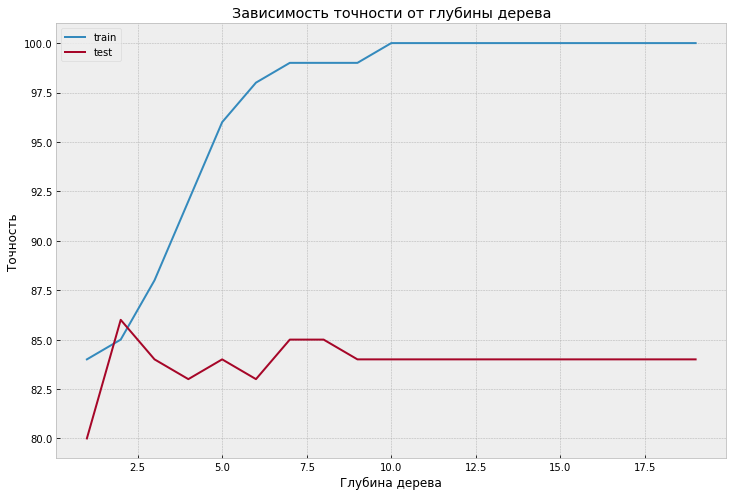

In [167]:
depths = list(range(1, 20))

train_accuracy = []
test_accuracy = []
for i in depths:
    model = DecisionTreeClassifier(max_depth=i, random_state=42)
    model.fit(x_train, y_train)
    train_accuracy.append(int(accuracy_score(y_train, model.predict(x_train)) * 100))
    test_accuracy.append(int(accuracy_score(y_test, model.predict(x_test)) * 100))
    
plt.style.use('bmh')
plt.figure(figsize=(12, 8))
plt.title('Зависимость точности от глубины дерева')
plt.plot(depths, train_accuracy, label='train')
plt.plot(depths, test_accuracy, label='test')
plt.ylabel('Точность')
plt.xlabel('Глубина дерева')
plt.legend()
plt.show()

### Регрессия

In [168]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [172]:
model = LinearRegression()
model.fit(x_train, y_train)
print('Линейная регрессия:', round(mean_squared_error(y_test, model.predict(x_test)), 2))

model = DecisionTreeRegressor()
model.fit(x_train, y_train)
print('Дерево решений:', round(mean_squared_error(y_test, model.predict(x_test)), 2))

Линейная регрессия: 24.29
Дерево решений: 10.75


### DecisionTree - рандомизированный алгоритм, поэтому бывает вот так

In [173]:
for i in range(5):
    print(f'Запуск {i + 1}')
    model = LinearRegression()
    model.fit(x_train, y_train)
    print('Линейная регрессия:', round(mean_squared_error(y_test, model.predict(x_test)), 2))

    model = DecisionTreeRegressor()
    model.fit(x_train, y_train)
    print(f'Дерево решений:', round(mean_squared_error(y_test, model.predict(x_test)), 2))
    print()

Запуск 1
Линейная регрессия: 24.29
Дерево решений: 21.8

Запуск 2
Линейная регрессия: 24.29
Дерево решений: 22.32

Запуск 3
Линейная регрессия: 24.29
Дерево решений: 10.66

Запуск 4
Линейная регрессия: 24.29
Дерево решений: 17.44

Запуск 5
Линейная регрессия: 24.29
Дерево решений: 22.41



### Поэтому фиксируем random_state (это не гиперпараметр!)

In [174]:
for i in range(5):
    print(f'Запуск {i + 1}')
    model = LinearRegression()
    model.fit(x_train, y_train)
    print('Линейная регрессия:', round(mean_squared_error(y_test, model.predict(x_test)), 2))

    model = DecisionTreeRegressor(random_state=7)
    model.fit(x_train, y_train)
    print(f'Дерево решений:', round(mean_squared_error(y_test, model.predict(x_test)), 2))
    print()

Запуск 1
Линейная регрессия: 24.29
Дерево решений: 10.62

Запуск 2
Линейная регрессия: 24.29
Дерево решений: 10.62

Запуск 3
Линейная регрессия: 24.29
Дерево решений: 10.62

Запуск 4
Линейная регрессия: 24.29
Дерево решений: 10.62

Запуск 5
Линейная регрессия: 24.29
Дерево решений: 10.62



### А еще лучше - использовать при этом кросс-валидацию

In [175]:
def scorer_func(model, X, y):
    return mean_squared_error(y, model.predict(X))


model = LinearRegression()
print(
    'Линейная регрессия:', 
    round(np.mean(cross_val_score(model, x, y, cv=4, scoring=scorer_func)), 2)
)

model = DecisionTreeRegressor(random_state=7)
print(
    'Дерево решений:', 
    round(np.mean(cross_val_score(model, x, y, cv=4, scoring=scorer_func)), 2)
)

Линейная регрессия: 42.37
Дерево решений: 37.18


### Визуализация и интерпретация модели

In [176]:
model = DecisionTreeRegressor(random_state=42, max_depth=3)
model.fit(x_train, y_train)

print(export_text(model, feature_names=list(x.columns)))

|--- RM <= 6.94
|   |--- LSTAT <= 14.40
|   |   |--- DIS <= 1.38
|   |   |   |--- value: [44.48]
|   |   |--- DIS >  1.38
|   |   |   |--- value: [22.90]
|   |--- LSTAT >  14.40
|   |   |--- CRIM <= 6.93
|   |   |   |--- value: [17.06]
|   |   |--- CRIM >  6.93
|   |   |   |--- value: [11.90]
|--- RM >  6.94
|   |--- RM <= 7.44
|   |   |--- LSTAT <= 15.76
|   |   |   |--- value: [33.30]
|   |   |--- LSTAT >  15.76
|   |   |   |--- value: [14.10]
|   |--- RM >  7.44
|   |   |--- RAD <= 16.00
|   |   |   |--- value: [45.56]
|   |   |--- RAD >  16.00
|   |   |   |--- value: [21.90]



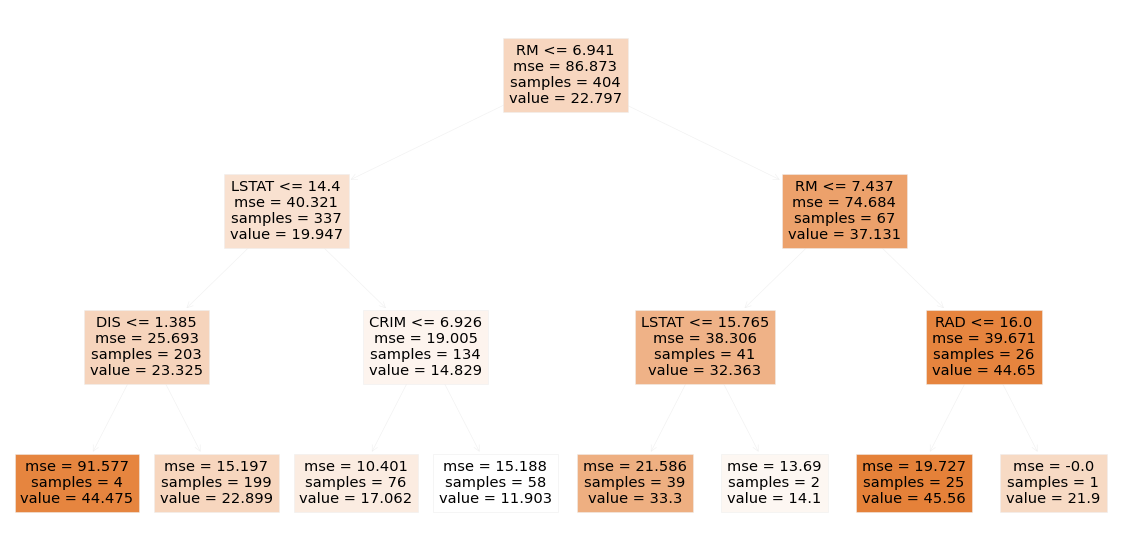

In [15]:
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=list(x.columns))
plt.show()

In [16]:
!pip install graphviz

import graphviz

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


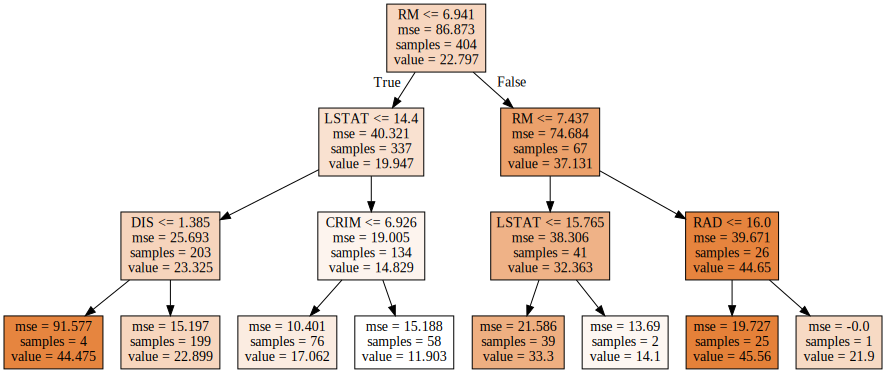

In [177]:
dot_data = export_graphviz(model, filled=True, feature_names=list(x.columns))

graph = graphviz.Source(dot_data, format="png") 
graph

In [18]:
!pip install dtreeviz

from dtreeviz.trees import dtreeviz 

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


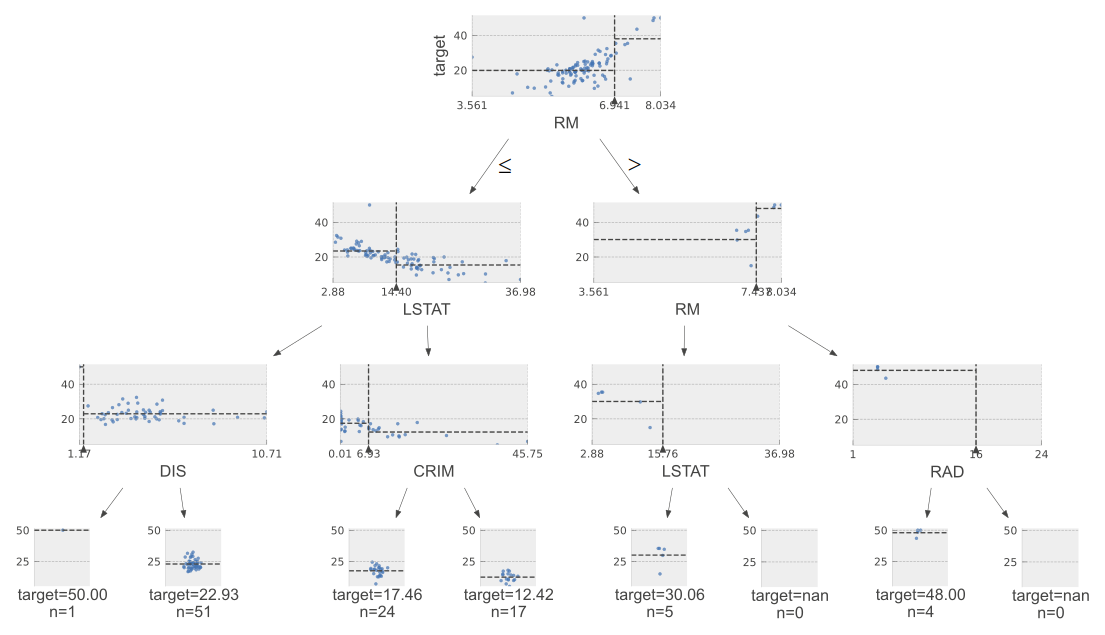

In [19]:
viz = dtreeviz(model, x_test, y_test, feature_names=list(x.columns), scale=1.8, target_name='target')

viz

### Сравнение распределений

#### Нужно, чтобы распределение трейна и теста было похожим

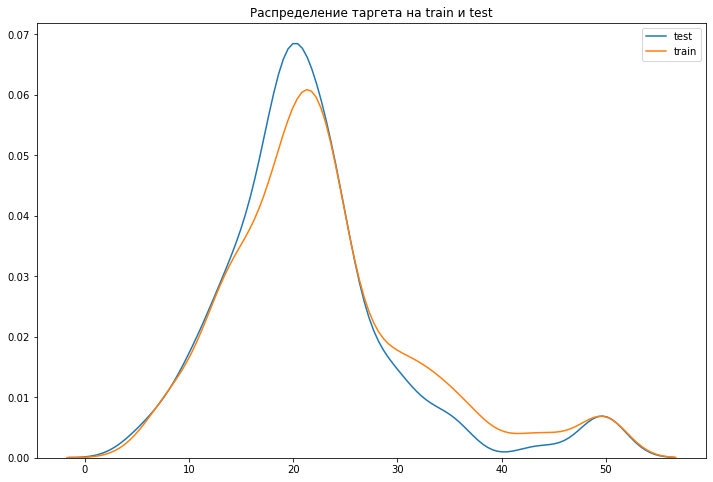

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

plt.figure(figsize=(12, 8))
plt.title('Распределение таргета на train и test')
sns.kdeplot(y_test, label='test')
sns.kdeplot(y_train, label='train')
plt.show()

#### Тогда и результаты на тесте будут похожими на правду

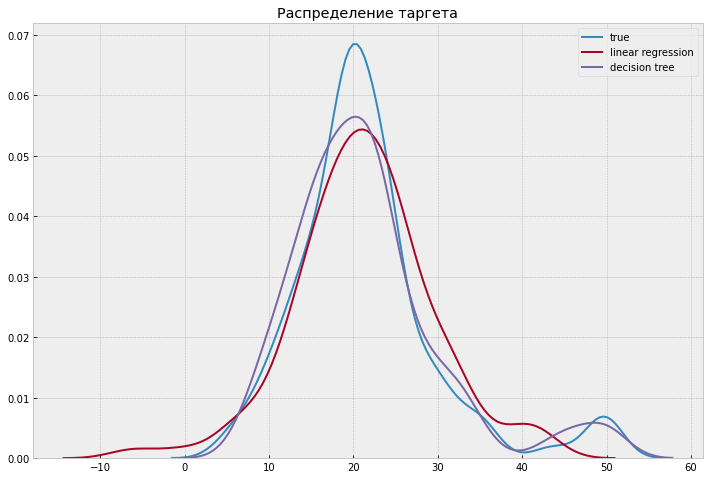

In [68]:
model = LinearRegression()
model.fit(x_train, y_train)

tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)

plt.figure(figsize=(12, 8))
plt.title('Распределение таргета')
sns.kdeplot(y_test, label='true')
sns.kdeplot(model.predict(x_test), label='linear regression')
sns.kdeplot(tree.predict(x_test), label='decision tree')
plt.show()

In [69]:
print('Линейная регрессия:', round(mean_squared_error(y_test, model.predict(x_test)), 2))
print('Дерево решений:', round(mean_squared_error(y_test, tree.predict(x_test)), 2))

Линейная регрессия: 24.29
Дерево решений: 22.84


#### Иногда полезно клипать предикты, особенно для линейной регрессии

In [54]:
predict = model.predict(x_test)
predict_clipped = np.clip(predict, a_min=0, a_max=None)

print(f'До np.clip:    {round(mean_squared_error(y_test, predict), 2)}')
print(f'После np.clip: {round(mean_squared_error(y_test, predict_clipped), 2)}')

До np.clip:    24.29
После np.clip: 23.03


In [55]:
predict = model.predict(x_test)
predict_clipped = np.clip(predict, a_min=10, a_max=None)

print(f'До np.clip:    {round(mean_squared_error(y_test, predict), 2)}')
print(f'После np.clip: {round(mean_squared_error(y_test, predict_clipped), 2)}')

До np.clip:    24.29
После np.clip: 19.99


#### Если распределения отличаются, то все может быть плохо

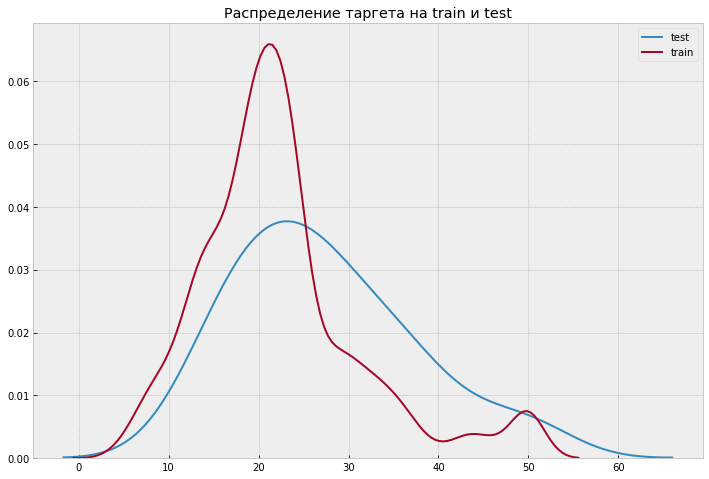

In [141]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=10)

plt.figure(figsize=(12, 8))
plt.title('Распределение таргета на train и test')
sns.kdeplot(y_test, label='test')
sns.kdeplot(y_train, label='train')
plt.show()

#### Линейной регрессии особенно плохо

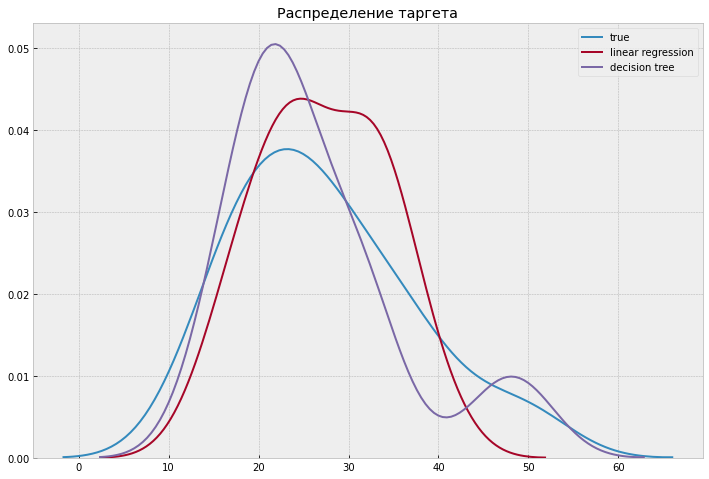

In [142]:
model = LinearRegression()
model.fit(x_train, y_train)

tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)

plt.figure(figsize=(12, 8))
plt.title('Распределение таргета')
sns.kdeplot(y_test, label='true')
sns.kdeplot(model.predict(x_test), label='linear regression')
sns.kdeplot(tree.predict(x_test), label='decision tree')
plt.show()

#### Ну и метрики стали хуже

In [143]:
print('Линейная регрессия:', round(mean_squared_error(y_test, model.predict(x_test)), 2))
print('Дерево решений:', round(mean_squared_error(y_test, tree.predict(x_test)), 2))

Линейная регрессия: 26.92
Дерево решений: 26.47


## Случайный лес

### Случайный лес по метрикам может быть значительно лучше простых моделей

In [178]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)

tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)

forest = RandomForestRegressor()
forest.fit(x_train, y_train)

pass

In [145]:
def scorer_func(model, X, y):
    return mean_squared_error(y, model.predict(X))

model = LinearRegression()
print(
    'Линейная регрессия:', 
    round(np.mean(cross_val_score(model, x, y, cv=4, scoring=scorer_func)), 2)
)

tree = DecisionTreeRegressor(random_state=11)
print(
    'Дерево решений:', 
    round(np.mean(cross_val_score(tree, x, y, cv=4, scoring=scorer_func)), 2)
)

forest = RandomForestRegressor(n_estimators=1, random_state=11)
print(
    'Случайный лес, 1 дерево:', 
    round(np.mean(cross_val_score(forest, x, y, cv=4, scoring=scorer_func)), 2)
)

forest = RandomForestRegressor(n_estimators=100, random_state=11)
print(
    'Случайный лес, 100 деревьев:', 
    round(np.mean(cross_val_score(forest, x, y, cv=4, scoring=scorer_func)), 2)
)

Линейная регрессия: 42.37
Дерево решений: 38.06
Случайный лес, 1 дерево: 37.89
Случайный лес, 100 деревьев: 22.55


### Но и учится он тоже дольше

In [146]:
%%timeit

model = DecisionTreeRegressor()
model.fit(x_train, y_train)

3.89 ms ± 450 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [79]:
%%timeit

model = RandomForestRegressor(n_estimators=100)
model.fit(x_train, y_train)

239 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
%%timeit

model = RandomForestRegressor(n_estimators=1000)
model.fit(x_train, y_train)

2.59 s ± 225 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Зато отлично параллелится

In [95]:
%%timeit

model = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
model.fit(x_train, y_train)

1.48 s ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Полезная библиотека с progress bar'ами

In [21]:
!pip install tqdm

from tqdm.notebook import tqdm_notebook

Looking in indexes: http://pypi.s/unisearch/ds, http://pypi.s/root/pypi/+simple/, http://pypi.s/unisearch_expl/dev


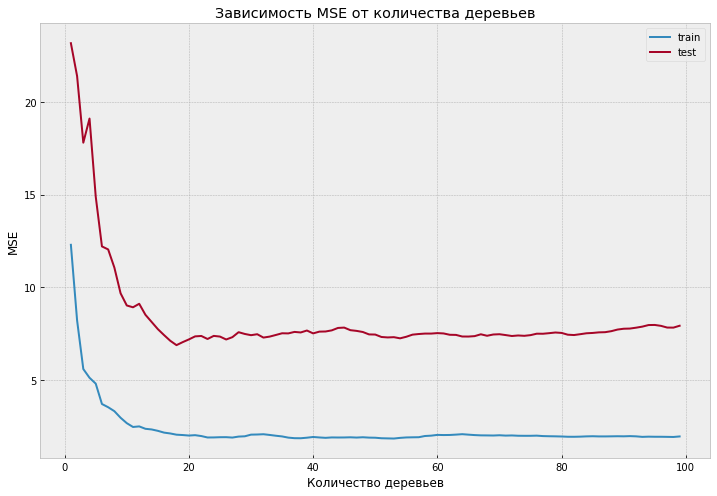

In [179]:
nums = list(range(1, 100))

train_mse = []
test_mse = []
for i in tqdm_notebook(nums):
    model = RandomForestRegressor(n_estimators=i, random_state=42)
    model.fit(x_train, y_train)
    train_mse.append(mean_squared_error(y_train, model.predict(x_train)))
    test_mse.append(mean_squared_error(y_test, model.predict(x_test)))
    
plt.style.use('bmh')
plt.figure(figsize=(12, 8))
plt.title('Зависимость MSE от количества деревьев')
plt.plot(nums, train_mse, label='train')
plt.plot(nums, test_mse, label='test')
plt.ylabel('MSE')
plt.xlabel('Количество деревьев')
plt.legend()
plt.show()

### Коротко о том, почему bootstap рулит

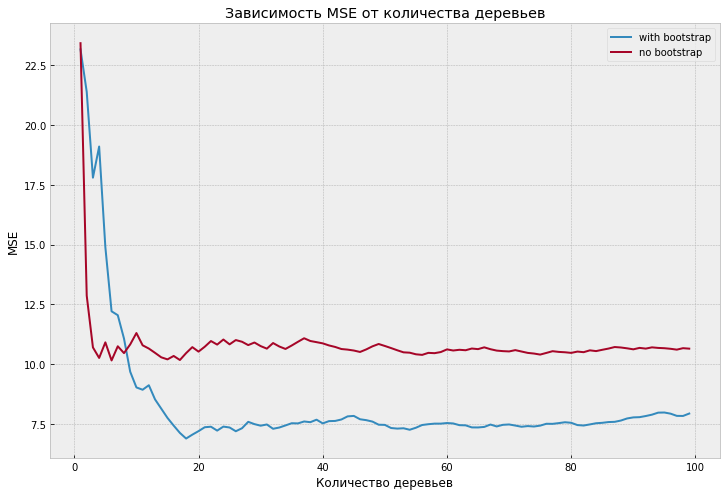

In [94]:
nums = list(range(1, 100))

boots_mse = []
no_boots_mse = []
for i in tqdm_notebook(nums):
    model = RandomForestRegressor(n_estimators=i, random_state=42)
    model.fit(x_train, y_train)
    boots_mse.append(mean_squared_error(y_test, model.predict(x_test)))
    
    model = RandomForestRegressor(n_estimators=i, random_state=42, bootstrap=False)
    model.fit(x_train, y_train)
    no_boots_mse.append(mean_squared_error(y_test, model.predict(x_test)))
    
plt.style.use('bmh')
plt.figure(figsize=(12, 8))
plt.title('Зависимость MSE от количества деревьев')
plt.plot(nums, boots_mse, label='with bootstrap')
plt.plot(nums, no_boots_mse, label='no bootstrap')
plt.ylabel('MSE')
plt.xlabel('Количество деревьев')
plt.legend()
plt.show()

### А теперь посмотрим, как на качество влияют гиперпараметры

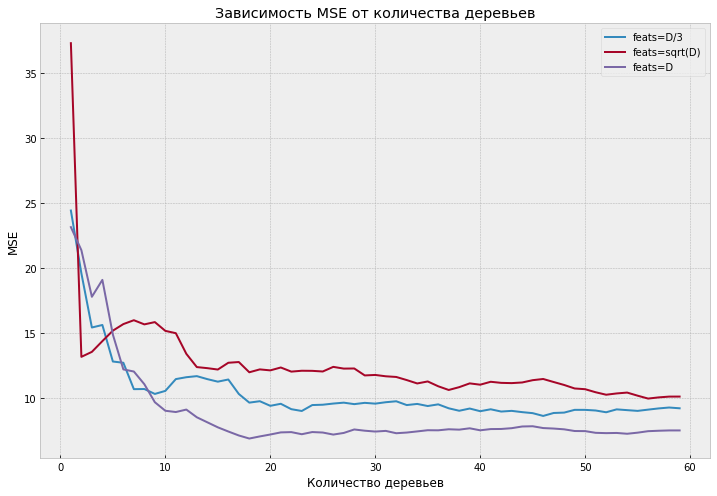

In [102]:
nums = list(range(1, 60))

boots_mse = []
no_boots_mse = []
tmp_mse = []

for i in tqdm_notebook(nums):
    model = RandomForestRegressor(n_estimators=i, random_state=42, max_features=int(len(x.columns) // 3))
    model.fit(x_train, y_train)
    boots_mse.append(mean_squared_error(y_test, model.predict(x_test)))
    
    model = RandomForestRegressor(n_estimators=i, random_state=42, max_features=int(np.sqrt(len(x.columns))))
    model.fit(x_train, y_train)
    no_boots_mse.append(mean_squared_error(y_test, model.predict(x_test)))
    
    model = RandomForestRegressor(n_estimators=i, random_state=42, max_features=len(x.columns))
    model.fit(x_train, y_train)
    tmp_mse.append(mean_squared_error(y_test, model.predict(x_test)))
    
plt.style.use('bmh')
plt.figure(figsize=(12, 8))
plt.title('Зависимость MSE от количества деревьев')
plt.plot(nums, boots_mse, label='feats=D/3')
plt.plot(nums, no_boots_mse, label='feats=sqrt(D)')
plt.plot(nums, tmp_mse, label='feats=D')
plt.ylabel('MSE')
plt.xlabel('Количество деревьев')
plt.legend()
plt.show()

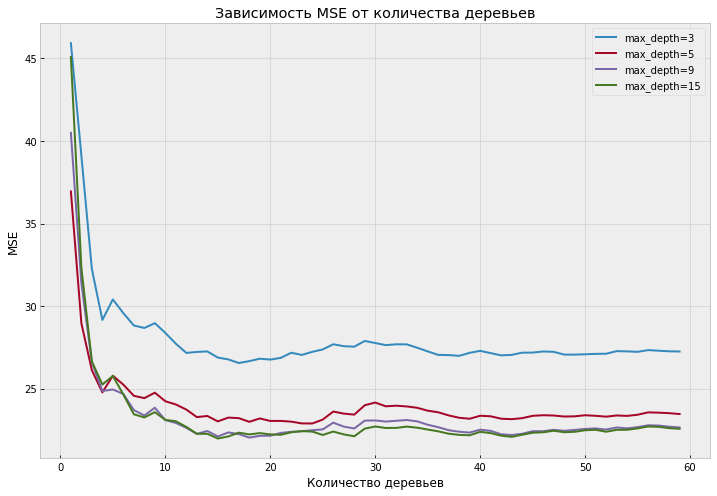

In [110]:
nums = list(range(1, 60))

boots_mse = []
no_boots_mse = []
tmp_mse = []
another_mse = []

for i in tqdm_notebook(nums):
    model = RandomForestRegressor(n_estimators=i, random_state=42, max_depth=3, n_jobs=-1)
    boots_mse.append(np.mean(cross_val_score(model, x, y, cv=4, scoring=scorer_func)))
    
    model = RandomForestRegressor(n_estimators=i, random_state=42, max_depth=5, n_jobs=-1)
    no_boots_mse.append(np.mean(cross_val_score(model, x, y, cv=4, scoring=scorer_func)))
    
    model = RandomForestRegressor(n_estimators=i, random_state=42, max_depth=9, n_jobs=-1)
    tmp_mse.append(np.mean(cross_val_score(model, x, y, cv=4, scoring=scorer_func)))
    
    model = RandomForestRegressor(n_estimators=i, random_state=42, max_depth=15, n_jobs=-1)
    another_mse.append(np.mean(cross_val_score(model, x, y, cv=4, scoring=scorer_func)))
    
plt.style.use('bmh')
plt.figure(figsize=(12, 8))
plt.title('Зависимость MSE от количества деревьев')
plt.plot(nums, boots_mse, label='max_depth=3')
plt.plot(nums, no_boots_mse, label='max_depth=5')
plt.plot(nums, tmp_mse, label='max_depth=9')
plt.plot(nums, another_mse, label='max_depth=15')
plt.ylabel('MSE')
plt.xlabel('Количество деревьев')
plt.legend()
plt.show()

### Можно взять любое дерево из леса по индексу

In [180]:
print(round(np.mean(cross_val_score(model.estimators_[0], x, y, cv=4, scoring=scorer_func)), 2))
print(round(np.mean(cross_val_score(model.estimators_[10], x, y, cv=4, scoring=scorer_func)), 2))

43.78
40.75


### Поэтому все прошлые эксперименты нужно было делать как-то так

In [183]:
num_est = [i for i in range(1, 60)]
kf = KFold(n_splits = 4)

res = []
scores = []
    
forest = RandomForestRegressor(n_estimators=60, n_jobs=-1)
forest.fit(x_train, y_train)

predict = []
for tree in forest.estimators_:
    predict.append(tree.predict(x_test))

res = []
for num in num_est:
    curr_pred = sum(predict[:num]) / num
    res.append(mean_squared_error(y_test, curr_pred))

if scores:
    for i in range(len(res)):
        scores[i] += res[i]
else:
    for i in range(len(res)):
        scores.append(res[i])

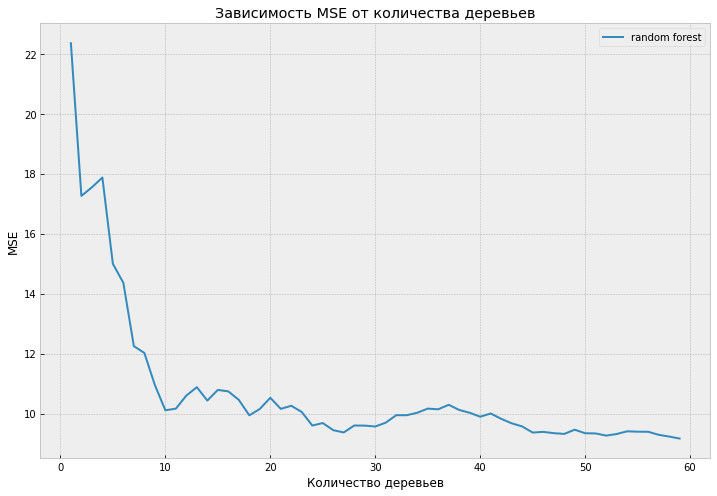

In [184]:
plt.style.use('bmh')
plt.figure(figsize=(12, 8))
plt.title('Зависимость MSE от количества деревьев')
plt.plot(num_est, scores, label='random forest')
plt.ylabel('MSE')
plt.xlabel('Количество деревьев')
plt.legend()
plt.show()